In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from scipy.stats import f_oneway
import ast

# Load data

In [2]:
df_merged = pd.read_csv('../data/Merged.csv')
#remove outliers
out_inds = [3, 4, 5, 27, 28, 29]
df_merged = (df_merged.drop(out_inds)).reset_index().drop(['index'],axis=1)
X = df_merged.iloc[:,1:-1].values
X = StandardScaler().fit_transform(X)

target_labels={'Fermented':[],'Cheesy':[],'Milky':[],'Fruity':[]}
for i in range(len(df_merged.index)):
    label = list(df_merged['Label'])[i]
    for k in target_labels.keys():
        if k == label:
            target_labels[k].append(1)
        else:
            target_labels[k].append(0)          

# Model selection

In [4]:
models_to_try = {
    'LR': LogisticRegression(penalty='l1',
        solver='saga',class_weight='balanced',
        random_state=42),
    'SVC': LinearSVC(penalty='l1',class_weight='balanced',dual=False,
        random_state=42),
    'BRR':BayesianRidge(),
    'GPC':GaussianProcessClassifier(random_state=42)}

In [5]:
result_df = pd.DataFrame(
    columns=['model', 'class', 'train_auc', 'test_auc'] )
N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in target_labels.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(model, X, y= y_labels,
            cv=N_CV, scoring='roc_auc', return_train_score=True,
            verbose=1,n_jobs=4 )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'class': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )
        result_df = result_df.append(sub_result_df)

LR
LR: Fermented


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Cheesy
LR: Milky
LR: Fruity
SVC
SVC: Fermented
SVC: Cheesy
SVC: Milky
SVC: Fruity
BRR
BRR: Fermented
BRR: Cheesy
BRR: Milky
BRR: Fruity
GPC
GPC: Fermented
GPC: Cheesy
GPC: Milky
GPC: Fruity


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concu

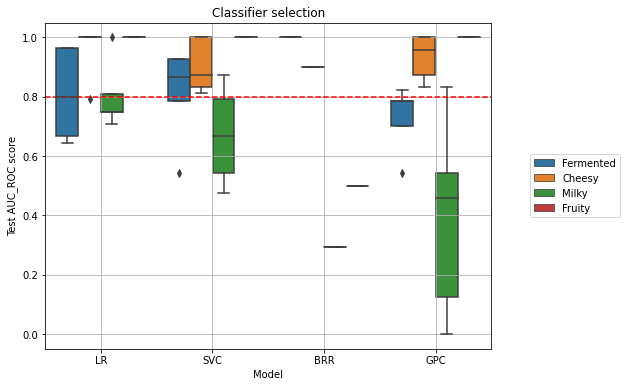

In [16]:
_, ax = plt.subplots(figsize= (8,6))
sns.boxplot(x='model', y='test_auc', data=result_df, hue='class', dodge=True, ax=ax)
ax.grid()
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.title('Classifier selection')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.xlabel('Model')
plt.ylabel('Test AUC_ROC score')
plt.savefig('../Figures/clf_select.svg',format='svg',dpi=150)

# Hyperparam optimization for Logit Regression

In [13]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver= 'saga',
            penalty = 'elasticnet',
            class_weight='balanced',
            max_iter = 500,
            verbose=1
        ),
        'param_dists': {
            'C': np.logspace(-1,2,15),
            'l1_ratio':np.linspace(0,1,num=21)
        }
    }
}

In [14]:
hyperopt_LR = {}

for y_name, y_labels in target_labels.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=50,scoring='roc_auc',n_jobs=4,
        cv=5,verbose=1,
        return_train_score=True )

    random_search_hyperopt.fit(  X ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False )
    hyperopt_LR[y_name] = hyperopt_results_df

dfs_with_class = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['class'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_class.append(hyperopt_df)
    
hyperopt_LR_df = pd.concat( dfs_with_class, axis=0, ignore_index=True)

Fermented
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Epoch 1, change: 1.00000000
Epoch 2, change: 0.30151455
Epoch 3, change: 0.17501583
Epoch 4, change: 0.15991247
Epoch 5, change: 0.10395774
Epoch 6, change: 0.04946326
Epoch 7, change: 0.02963728
Epoch 8, change: 0.03242972
Epoch 9, change: 0.02697282
Epoch 10, change: 0.02070714
Epoch 11, change: 0.01820019
Epoch 12, change: 0.01421314
Epoch 13, change: 0.01208750
Epoch 14, change: 0.01052914
Epoch 15, change: 0.00977886
Epoch 16, change: 0.00901228
Epoch 17, change: 0.00732143
Epoch 18, change: 0.00629490
Epoch 19, change: 0.00586053
Epoch 20, change: 0.00497668
Epoch 21, change: 0.00432380
Epoch 22, change: 0.00395827
Epoch 23, change: 0.00358080
Epoch 24, change: 0.00329724
Epoch 25, change: 0.00263420
Epoch 26, change: 0.00247779
Epoch 27, change: 0.00223375
Epoch 28, change: 0.00193790
Epoch 29, change: 0.00175509
Epoch 30, change: 0.00155854
Epoch 31, change: 0.00143597
Epoch 32, change: 0.00117060
Epoch 33,

/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/ho

poch 138, change: 0.00165481
Epoch 139, change: 0.00165043
Epoch 140, change: 0.00162030
Epoch 141, change: 0.00161787
Epoch 142, change: 0.00156910
Epoch 143, change: 0.00157331
Epoch 144, change: 0.00153561
Epoch 145, change: 0.00152864
Epoch 146, change: 0.00152604
Epoch 147, change: 0.00150244
Epoch 148, change: 0.00151845
Epoch 149, change: 0.00145611
Epoch 150, change: 0.00146684
Epoch 151, change: 0.00145656
Epoch 152, change: 0.00142064
Epoch 153, change: 0.00141434
Epoch 154, change: 0.00140094
Epoch 155, change: 0.00138832
Epoch 156, change: 0.00136251
Epoch 157, change: 0.00136938
Epoch 158, change: 0.00138202
Epoch 159, change: 0.00134452
Epoch 160, change: 0.00132608
Epoch 161, change: 0.00132293
Epoch 162, change: 0.00130056
Epoch 163, change: 0.00128464
Epoch 164, change: 0.00129667
Epoch 165, change: 0.00127471
Epoch 166, change: 0.00125769
Epoch 167, change: 0.00124219
Epoch 168, change: 0.00123610
Epoch 169, change: 0.00121937
Epoch 170, change: 0.00121017
Epoch 171, 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1

.00012303
Epoch 394, change: 0.00012265
Epoch 395, change: 0.00012190
Epoch 396, change: 0.00012140
Epoch 397, change: 0.00012091
Epoch 398, change: 0.00011928
Epoch 399, change: 0.00011925
Epoch 400, change: 0.00011864
Epoch 401, cpoch 242, change: 0.00098102
Epoch 243, change: 0.00097619
Epoch 244, change: 0.00097645
Epoch 245, change: 0.00095484
Epoch 246, change: 0.00094734
Epoch 247, change: 0.00095648
Epoch 248, change: 0.00094594
Epoch 249, change: 0.00093640
Epoch 250, change: 0.00092596
Epoch 251, change: 0.00092226
Epoch 252, change: 0.00092170
Epoch 253, change: 0.00091568
Epoch 254, change: 0.00091644
Epoch 255, change: 0.00090970
Epoch 256, change: 0.00089266
Epoch 257, change: 0.00089800
Epoch 258, change: 0.00089140
Epoch 259, change: 0.00088665
Epoch 260, change: 0.00088361
Epoch 261, change: 0.00087342
Epoch 262, change: 0.00087556
Epoch 263, change: 0.00086863
Epoch 264, change: 0.00085818
Epoch 265, change: 0.00085548
Epoch 266, change: 0.00086008
Epoch 267, change: 

Epoch 377, change: 0.00054495
Epoch 378, change: 0.00054176
Epoch 379, change: 0.00054107
Epoch 380, change: 0.00053789
Epoch 381, change: 0.00053601
Epoch 382, change: 0.00053695
Epoch 383, change: 0.00053492
Epoch 384, change: 0.00053264
Epoch 385, change: 0.00053224
Epoch 386, change: 0.00053217
Epoch 387, change: 0.00053012
Epoch 388, change: 0.00051532
Epoch 389, change: 0.00052206
Epoch 390, change: 0.00051940
Epoch 391, change: 0.00051520
Epoch 392, change: 0.00051459
Epoch 393, change: 0.00051207
Epoch 394, change: 0.00051211
Epoch 395, change: 0.00051085
Epoch 396, change: 0.00050891
Epoch 397, change: 0.00050467
Epoch 398, change: 0.00050214
Epoch 399, change: 0.00050320
Epoch 400, change: 0.00049948
Epoch 401, change: 0.00049768
Epoch 402, change: 0.00049765
Epoch 403, change: 0.00049699
Epoch 404, change: 0.00049086
Epoch 405, change: 0.00049169
Epoch 406, change: 0.00049189
Epoch 407, change: 0.00048719
Epoch 408, change: 0.00048586
Epoch 409, change: 0.00048492
Epoch 410,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
hyperopt_LR_df.to_csv('../data/hyperopt_LR.csv')

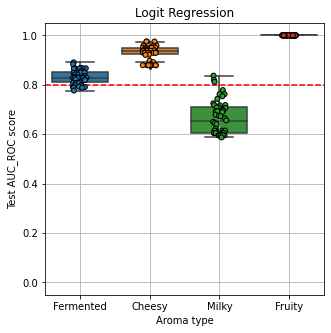

In [12]:
hyperopt_LR_df = pd.read_csv('../data/hyperopt_LR.csv')
plt.figure( figsize=(5,5))
sns.boxplot(x='class', y='mean_test_score', data=hyperopt_LR_df)
sns.stripplot(x='class', y='mean_test_score', edgecolor='black',linewidth=1, data=hyperopt_LR_df)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('Test AUC_ROC score')
plt.xlabel('Aroma type')
plt.title('Logit Regression')
plt.ylim([-0.05,1.05])
plt.grid()
plt.savefig('../Figures/LR_aucroc.svg',format='svg',dpi=150)  

# Hyperparam optimization for Linear SVC

In [3]:
hyperopt_models = {
    'SVM': {
        'model': LinearSVC(penalty = 'l1', class_weight='balanced', max_iter = 2000, dual=False,random_state=42),
        'param_dists': {
            'C': np.logspace(-1,2,15),
            'fit_intercept':[True, False] }
    }
}

In [4]:
hyperopt_SVM = {}

for y_name, y_labels in target_labels.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['SVM']['model'],
        hyperopt_models['SVM']['param_dists'],
        n_iter=50,scoring='roc_auc',n_jobs=4,
        cv=5,verbose=1,
        return_train_score=True )

    random_search_hyperopt.fit(  X ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score', ascending=False )
    hyperopt_SVM[y_name] = hyperopt_results_df

dfs_with_class = []
for y_name, hyperopt_df in hyperopt_SVM.items():
    hyperopt_df['class'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_class.append(hyperopt_df)
    
hyperopt_SVM_df = pd.concat( dfs_with_class, axis=0, ignore_index=True)

Fermented
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Cheesy
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Milky
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fruity
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [5]:
hyperopt_SVM_df.to_csv('../data/hyperopt_SVM.csv')

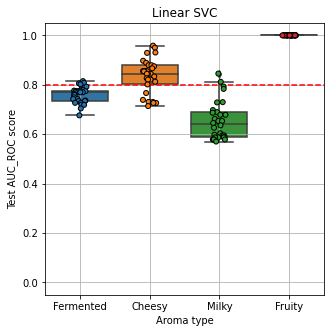

In [14]:
hyperopt_SVM_df = pd.read_csv('../data/hyperopt_SVM.csv')
plt.figure( figsize=(5,5))
sns.boxplot(x='class', y='mean_test_score', data=hyperopt_SVM_df)
sns.stripplot(x='class', y='mean_test_score', edgecolor='black',linewidth=1, data=hyperopt_SVM_df)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('Test AUC_ROC score')
plt.xlabel('Aroma type')
plt.title('Linear SVC')
plt.ylim([-0.05,1.05])
plt.grid()
plt.savefig('../Figures/SVM_aucroc.svg',format='svg',dpi=150)  

# Assess feature importances for LR

In [22]:
import shap
from sklearn.model_selection import train_test_split

In [23]:
hyperopt_LR_df = pd.read_csv('../data/hyperopt_LR.csv')
hyperopt_SVM_df = pd.read_csv('../data/hyperopt_SVM.csv')
cols = [ x  for x in list(df_merged.columns) if (x!= 'Label' )and( x!= 'Sample') ]
X_fi = pd.DataFrame( X, columns= cols, index=df_merged.index)

shap_vals= {}

for aroma in target_labels.keys():
    sub_table = hyperopt_LR_df[ hyperopt_LR_df['class']==aroma]
    sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
    params = ast.literal_eval( list(sub_table['params'])[0])
    clf = LogisticRegression(solver= 'saga', penalty = 'elasticnet', class_weight='balanced',
            max_iter = 500, verbose=1)
    clf.set_params( l1_ratio = params['l1_ratio'])
    clf.set_params( C = params['C'])
    y = pd.Series( target_labels[aroma] )
    X_train, X_test, y_train, y_test = train_test_split( X_fi, y, test_size=0.3, random_state=42)
    clf.fit(X_train, y_train)
    explainer = shap.Explainer(clf, X_train )
    shap_vals[aroma] = explainer(X_test)

ge: 0.00032838
Epoch 395, change: 0.00032656
Epoch 396, change: 0.00032586
Epoch 397, change: 0.00032457
Epoch 398, change: 0.00032385
Epoch 399, change: 0.00032229
Epoch 400, change: 0.00032150
Epoch 401, change: 0.00032040
Epoch 402, change: 0.00031942
Epoch 403, change: 0.00031801
Epoch 404, change: 0.00031730
Epoch 405, change: 0.00031636
Epoch 406, change: 0.00031503
Epoch 407, change: 0.00031391
Epoch 408, change: 0.00031307
Epoch 409, change: 0.00031213
Epoch 410, change: 0.00031113
Epoch 411, change: 0.00030998
Epoch 412, change: 0.00030881
Epoch 413, change: 0.00030792
Epoch 414, change: 0.00030689
Epoch 415, change: 0.00030605
Epoch 416, change: 0.00030480
Epoch 417, change: 0.00030400
Epoch 418, change: 0.00030326
Epoch 419, change: 0.00030215
Epoch 420, change: 0.00030122
Epoch 421, change: 0.00030005
Epoch 422, change: 0.00029933
Epoch 423, change: 0.00029842
Epoch 424, change: 0.00029753
Epoch 425, change: 0.00029641
Epoch 426, change: 0.00029531
Epoch 427, change: 0.0002

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


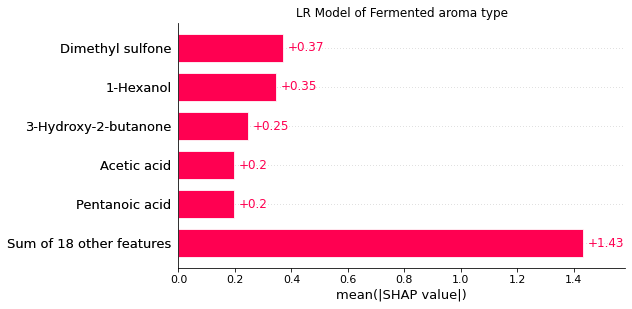

In [65]:
aroma = 'Fermented'
plt.title("LR Model of " + aroma + " aroma type")
shap.plots.bar( shap_vals[aroma],max_display=6,show = False)
plt.savefig('../Figures/LRf_'+aroma+'.svg',format='svg',dpi=150)  

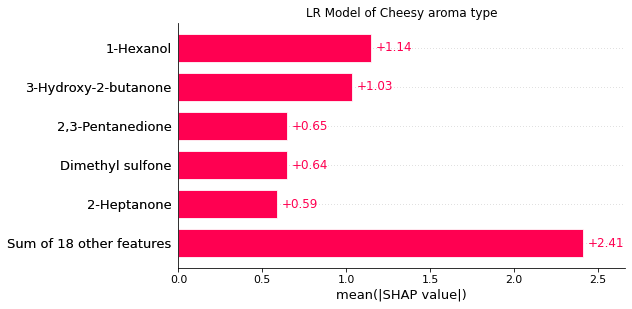

In [67]:
aroma = 'Cheesy'
plt.title("LR Model of " + aroma + " aroma type")
shap.plots.bar( shap_vals[aroma],max_display=6,show = False)
plt.savefig('../Figures/LRf_'+aroma+'.svg',format='svg',dpi=150)  

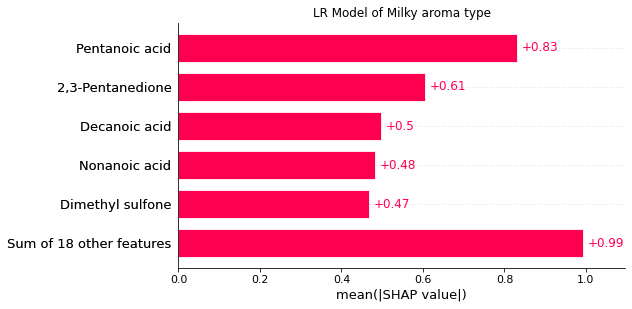

In [68]:
aroma = 'Milky'
plt.title("LR Model of " + aroma + " aroma type")
shap.plots.bar( shap_vals[aroma],max_display=6,show = False)
plt.savefig('../Figures/LRf_'+aroma+'.svg',format='svg',dpi=150)  

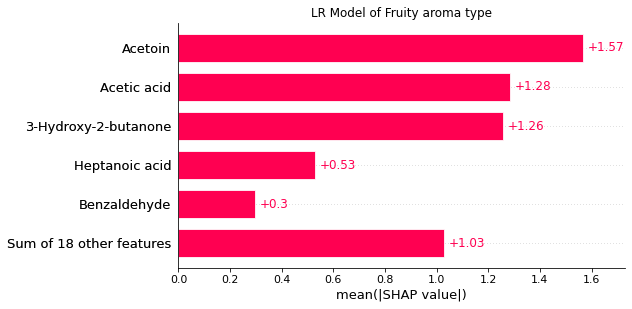

In [69]:
aroma = 'Fruity'
plt.title("LR Model of " + aroma + " aroma type")
shap.plots.bar( shap_vals[aroma],max_display=6,show = False)
plt.savefig('../Figures/LRf_'+aroma+'.svg',format='svg',dpi=150)  

# Feature distribution and ANOVA test
- faetures to study: Nonanoic acid, Pentanoic acid, Phenol, Acetic acid, 1-Hexanol, Dimethyl sulfone, Acetoin, Acetaldehyde

In [31]:
def cal_anova( data, feature ):
    temp = {x:[] for x in  np.unique( data['Label'] ) }
    for i in range(len(data.index)):
        temp[ list(data['Label'])[i] ].append( list(data[feature])[i] )
    F,p = f_oneway( *[temp[k] for k in temp.keys()] )
    return p 
    

In [53]:
df_merged.columns

Index(['Sample', 'Acetaldehyde', '2,3-Butanedione', '2,3-Pentanedione',
       '2-Heptanone', '3-Hydroxy-2-butanone', '1-Hexanol',
       'Dimethyl trisulfide', '2-Nonanone', 'Acetic acid', 'Benzaldehyde',
       '2-Undecanone', 'Butanoic acid', 'Pentanoic acid', 'Hexanoic acid',
       'Dimethyl sulfone', 'Heptanoic acid', 'Phenol', 'Octanoic acid',
       'Nonanoic acid', 'delta-Decalactone', 'Decanoic acid', 'Ethyl acetate',
       'Acetoin', 'Label'],
      dtype='object')

In [56]:
features2study = ['Dimethyl sulfone','1-Hexanol','3-Hydroxy-2-butanone', 'Pentanoic acid',
                  '2,3-Pentanedione', 'Pentanoic acid',
                 'Decanoic acid','Acetoin', 'Acetic acid']

In [57]:
for f in features2study:
    p = cal_anova( df_merged, f )
    print(f+' pval = ' + str(p))

Dimethyl sulfone pval = 1.1223133395272171e-05
1-Hexanol pval = 0.013525013593510911
3-Hydroxy-2-butanone pval = 1.2603554348644305e-09
Pentanoic acid pval = 0.0010467181655354615
2,3-Pentanedione pval = 0.0002540116096441974
Pentanoic acid pval = 0.0010467181655354615
Decanoic acid pval = 0.04128122955458689
Acetoin pval = 2.2549555517287668e-42
Acetic acid pval = 1.0747235743685429e-12


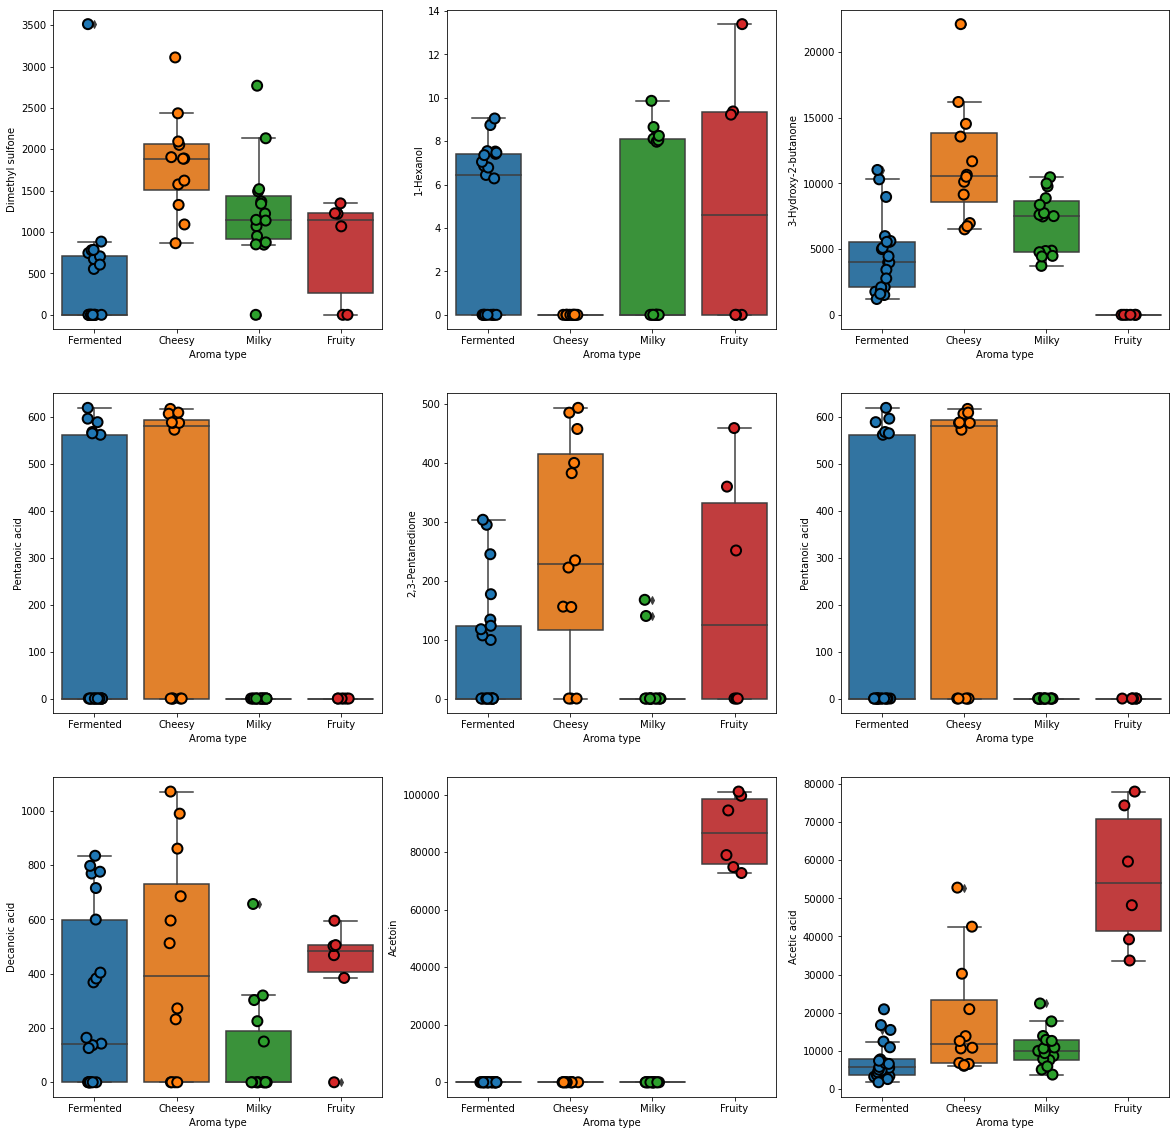

In [63]:
fig, axs = plt.subplots(3,3,figsize=(20,20))
for i in range(len(features2study)):
    x,y = int(i/3), int(i%3)
    sns.boxplot(x="Label", y=features2study[i],data=df_merged,ax = axs[x][y] ) 
    sns.stripplot(x="Label", y=features2study[i], size=10,edgecolor='black',linewidth=2,
                  data=df_merged,ax = axs[x][y] ) 
    axs[x][y].set_xlabel('Aroma type')
plt.savefig('../Figures/feature_distribution.svg',format='svg',dpi=150)  

# Oneway anova test for all features

In [32]:
from matplotlib.patches import Rectangle

In [33]:
Allfeatures = list(df_merged.columns)[1:-1]
pval_list = []
for f in Allfeatures:
    pval_list.append( (f,cal_anova( df_merged, f )) )
pval_list = sorted(pval_list, key=lambda tup: tup[1])

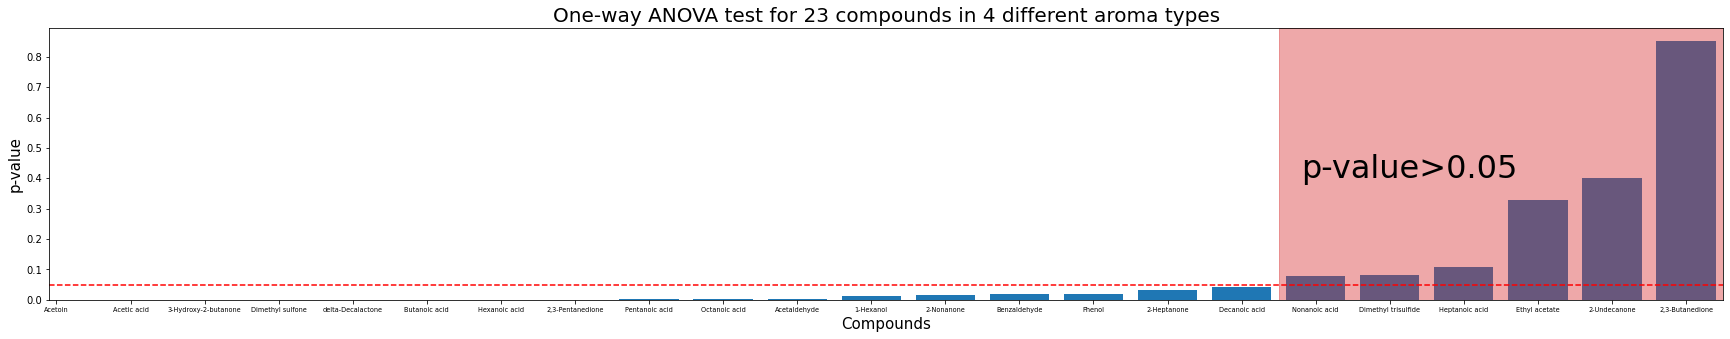

In [64]:
fig, ax = plt.subplots(1,1,figsize=(30,5))
ax.bar( [x[0] for x in pval_list], [x[1] for x in pval_list])
ax.xaxis.set_tick_params(labelsize=6.5)
ax.set_xlabel('Compounds',fontsize=15)
ax.set_ylabel('p-value',fontsize=15)
ax.axhline(y=0.05,color='r',linestyle='--')
ax.set_title('One-way ANOVA test for 23 compounds in 4 different aroma types',fontsize=20)
ax.set_xlim([-0.1,22.5])
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.text(x=16.8,y=0.4,s='p-value>0.05',fontsize=32)
ax.add_patch(Rectangle((16.5, ymin), 6.5, (ymax-ymin), color='tab:red', alpha=0.4))
plt.savefig('../Figures/anova.svg',format='svg',dpi=150) 